In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.signal import find_peaks
import pandas as pd

In [2]:
@njit
def kronecker(spin_1, spin_2):
    if int(spin_1)==int(spin_2):
        return 1
    else:
        return 0

In [3]:
@njit

def energy_per_site(spins,i,j,J,L):
    energy=(kronecker(spins[i][j],spins[(i+1)%L][j])+kronecker(spins[i][j],spins[i][(j+1)%L])+kronecker(spins[i][j],spins[i][j-1])+kronecker(spins[i][j],spins[i-1][j]))

    return -J*energy
    

In [4]:
@njit


def oneMCS(energy, beta,spins, J,states,q):
    L = np.shape(spins)[0] #length of lattice 
    N = L**2 #total lattice points 
    
    for n in range(N):
        i = np.random.randint(0,L) # choose some random index x
        j = np.random.randint(0,L) #choose some random index in y
        #Modulo function that you see under is for the boundary conditions. It is not applied to -1s
        #since arrays by default take care of them
        old_spin=spins[i,j]
        Eold = energy_per_site(spins,i,j,J,L)
        
        proposed_spin = np.random.randint(1,q+1)
        spins[i,j]=proposed_spin
        Enew = energy_per_site(spins,i,j,J,L) #energy with one changed spin 
        
        del_E = Enew - Eold
        
        omega = np.exp(-beta*del_E) #boltzmann weight
        
        r = np.random.random() #some random number
        
        if del_E<=0 or r<= omega:
            energy += del_E
            spins[i][j]=proposed_spin #flip spins
            
        else:
            spins[i][j]=old_spin
        
    return energy, spins        

In [5]:
@njit

def Total_Energy(spins,L):
    E=0
    for i in range(L):
        for j in range(L):
            E+=energy_per_site(spins,i,j,J=1,L=L)
    return E/2

In [6]:
@njit

def simulate(q,L, beta,J=1, n_mcs = 100_000):
    
    states=np.arange(1,q+1,1)

    spins = np.random.choice(states,(L,L))
        
    systemEnergy = np.zeros(n_mcs)
    #m = np.zeros_like(systemEnergy)
    systemEnergy[0]= Total_Energy(spins,L)#,np.sum(spins) #From the hamiltonian

    for mc in range(1,n_mcs):
        systemEnergy[mc], spins = oneMCS(energy=systemEnergy[mc-1], beta=beta, spins=spins,J=1, states=states,q=q)
        #m[mc] = np.sum(spins) 
        
    
    ## In the lines that follow, complete the simulate function to run `n_mcs` sweeps
    ## and store the energy and magnetisation in the arrays provided above.
    ## It should take roughly 20 lines of code or so.
    
    return systemEnergy

In [7]:
#FOR GOOD VALUES CHANGE MCS=50_000 AND L=32 OR MORE
mcs=1000
Temperature=np.linspace(0.5,1.5,150)
betas=1/Temperature
q_s=np.array([2,3,5,10])
L=16

In [8]:
average_E=np.zeros((len(q_s),len(Temperature)))
average_E_sqr=np.zeros((len(q_s),len(Temperature)))
C_v=np.zeros((len(q_s),len(Temperature)))

In [9]:
%%time
for i in range(len(q_s)):
    for j in range(len(Temperature)):
        E_arr=simulate(q=q_s[i],L=L,beta=betas[j],n_mcs=mcs)
        average_E[i][j]=np.mean(E_arr[-int(0.4*mcs):])
        average_E_sqr[i][j]=np.mean(E_arr[-int(0.4*mcs):]**2)
        C_v[i][j]=(average_E_sqr[i][j]-average_E[i][j]**2)*betas[j]**2

CPU times: user 3.91 s, sys: 38.6 ms, total: 3.95 s
Wall time: 3.98 s


In [10]:
T_analytic=np.zeros(len(q_s))
for i in range(len(q_s)):
    T_analytic[i]=1/np.log(1+np.sqrt(q_s[i]))

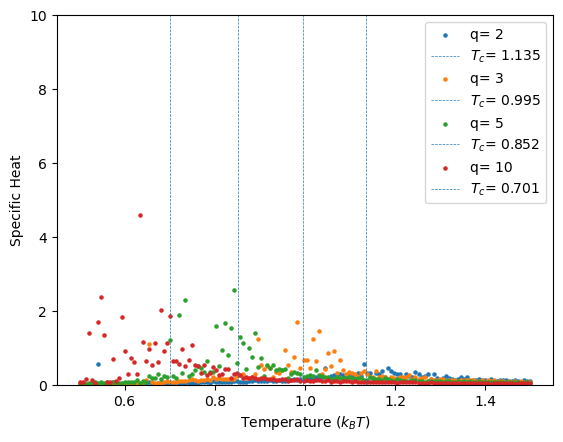

In [11]:
for i in range(len(q_s)):
    plt.scatter(Temperature,C_v[i]/(32*32),label='q= '+str(q_s[i]),s=5)
    plt.xlabel(r'Temperature ($k_B T$)')
    plt.ylim(0,10)
    plt.ylabel('Specific Heat')
    plt.axvline(T_analytic[i],ls='--',lw=0.5,label='$T_c$= '+str(np.round(T_analytic[i],3)))
    plt.legend()

In [12]:
mc_sweeps=25_00_000

In [18]:
def E_hist(E_0,bins,L,beta,cutoff):
    
    N=L*L
    H_E,E_bin=np.histogram(E_0[-cutoff:],bins=bins)
    energy=np.zeros(len(E_bin))
    
    for i in range(len(E_bin)-1):
        energy[i]=(E_bin[i]+E_bin[i+1])/2
    
    energy=energy[:-1]
    
    H_Ef,Ef=[],[]
    
    for i in range(len(H_E)):
        if H_E[i]!=0:
            H_Ef.append(H_E[i])
            Ef.append(energy[i])
    
    H_Ef,Ef=np.array(H_Ef),np.array(Ef)
    
    F=-np.log(H_Ef)+(beta-B_0)*Ef
    
    return Ef/N,F


def Peak_finder(E,B,L,bins,cutoff):
    x,y=E_hist(E,bins=bins,L=L,beta=B,cutoff=cutoff)
    a1,a2,a3,a4,a5,a6,a7,a8,a9=np.polyfit(x,y,8)
    Y=a1*x**8+a2*x**7+a3*x**6+a4*x**5+a5*x**4+a6*x**3+a7*x**2+a8*x+a9
    peaks,_=find_peaks(abs(Y),height=2,distance=5)
    if len(peaks)==1:
        return 'lol'
    else:
        delta=abs(Y[peaks[0]])-abs(Y[peaks[-1]])
        return peaks, [Y[peaks[0]],Y[peaks[-1]]],delta

In [14]:
#q=2
E_32_2=np.loadtxt('E_32_2.csv')
E_64_2=np.loadtxt('E_64_2.csv')
E_128_2=np.loadtxt('E_128_2.csv')
E_256_2=np.loadtxt('E_256_2.csv')
E_16_2=np.loadtxt('E_16_2.csv')
#q=3
E_32_3=np.loadtxt('E_32_3.csv')
E_64_3=np.loadtxt('E_64_3.csv')
E_128_3=np.loadtxt('E_128_3.csv')
E_256_3=np.loadtxt('E_256_3.csv')
E_16_3=np.loadtxt('E_16_3.csv')
#q=5
E_32_5=np.loadtxt('E_32_5.csv')
E_64_5=np.loadtxt('E_64_5.csv')
E_128_5=np.loadtxt('E_128_5.csv')
E_256_5=np.loadtxt('E_256_5.csv')
E_16_5=np.loadtxt('E_16_5.csv')
#q=10
E_32_10=np.loadtxt('E_32_10.csv')
E_64_10=np.loadtxt('E_64_10.csv')
E_128_10=np.loadtxt('E_128_10.csv')
E_256_10=np.loadtxt('E_256_10.csv')
E_16_10=np.loadtxt('E_16_10.csv')

Text(0.5, 1.0, 'q=10,L=16')

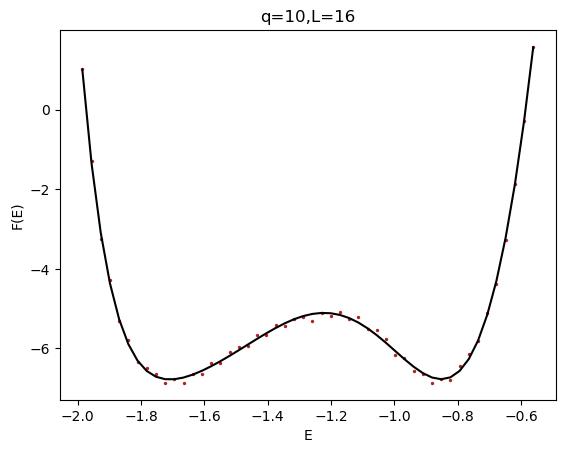

In [19]:
#q=10,L=16
B_0=np.log(1+np.sqrt(10))
B=1.4151010184574928
E,F=E_hist(E_16_10,50,16,B,len(E_16_10)//2)
plt.scatter(E,F,s=2,c='firebrick',label='Simulated')
x,y=E,F
a1,a2,a3,a4,a5,a6,a7,a8,a9=np.polyfit(x,y,8)
Y=a1*x**8+a2*x**7+a3*x**6+a4*x**5+a5*x**4+a6*x**3+a7*x**2+a8*x+a9
plt.xlabel('E')
plt.ylabel('F(E)')
plt.plot(x,Y,ls='-',c='k',label='Best fit')
plt.title('q=10,L=16')

In [21]:
%%time
guess=B_0-0.01
upper=B_0
lower=B_0-0.02
tolerance=1e-9
i=0
delta=1
max_itr=500
while abs(delta)>tolerance and i<max_itr:
    i+=1
    peaks,vals,delta=Peak_finder(E=E_16_10,L=16,B=(lower+upper)*0.5,bins=50,cutoff=len(E_16_10)//2)
    if delta>0:
        upper=guess
        lower=lower
        guess=0.5*(upper+lower)
        
    if delta<0:
        lower=guess
        upper=upper
        guess=0.5*(upper+lower)


B_16=guess

print('for 16 AND q=10 the guess should be ',guess)

for 16 AND q=10 the guess should be  1.4151010184578023
CPU times: user 503 ms, sys: 4.34 ms, total: 507 ms
Wall time: 505 ms


In [33]:
max_peaks,vals1=find_peaks(Y,height=-6)
vals=find_peaks(abs(Y),height=6)[1]

In [34]:
print(vals1)
print(vals)
#take negative of the second array and subtract it from the first value. 
#this will give delta. 

{'peak_heights': array([-5.10931147])}
{'peak_heights': array([6.77528263, 6.77528263])}


### If the Bisection Method DOES NOT WORK, MANUALLY GUESS THE BETA

FOR MAKING LIFE SIMPLE, WE HAVE PROVIDED THESE TO YOU\
The following is a sample guess:

In [67]:
def E_hist(E_0,bins,L,beta,cutoff):
    
    N=L*L
    H_E,E_bin=np.histogram(E_0[-cutoff:],bins=bins)
    energy=np.zeros(len(E_bin))
    
    for i in range(len(E_bin)-1):
        energy[i]=(E_bin[i]+E_bin[i+1])/2
    
    energy=energy[:-1]
    
    H_Ef,Ef=[],[]
    
    for i in range(len(H_E)):
        if H_E[i]!=0:
            H_Ef.append(H_E[i])
            Ef.append(energy[i])
    
    H_Ef,Ef=np.array(H_Ef),np.array(Ef)
    
    F=-np.log(H_Ef)+(beta-B_0)*Ef
    
    return Ef/N,F


def Peak_finder(E,B,L,bins,cutoff):
    x,y=E_hist(E,bins=bins,L=L,beta=B,cutoff=cutoff)
    a1,a2,a3,a4,a5,a6,a7,a8,a9=np.polyfit(x,y,8)
    Y=a1*x**8+a2*x**7+a3*x**6+a4*x**5+a5*x**4+a6*x**3+a7*x**2+a8*x+a9
    peaks,_=find_peaks(abs(y),height=2,distance=5)
    if len(peaks)==1:
        return 'lol'
    else:
        delta=(Y[peaks[0]])-(Y[peaks[-1]])
        return peaks, [Y[peaks[0]],Y[peaks[-1]]],delta

minima= -8.461930212681182
maxima=  -2.0298250601626933
delta=  6.4321051525184885


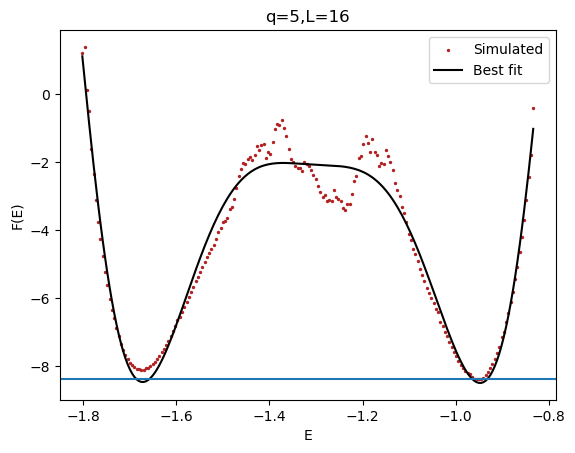

In [81]:
B_0=np.log(1+np.sqrt(10))
B=B_0*0.99965943
E,F=E_hist(E_64_10,200,64,B,len(E_256_5)-10000)
plt.scatter(E,F,s=2,c='firebrick',label='Simulated')
x,y=E,F
a1,a2,a3,a4,a5,a6,a7,a8,a9=np.polyfit(x,y,8)
Y=a1*x**8+a2*x**7+a3*x**6+a4*x**5+a5*x**4+a6*x**3+a7*x**2+a8*x+a9
plt.xlabel('E')
plt.ylabel('F(E)')
plt.plot(x,Y,ls='-',c='k',label='Best fit')
plt.title('q=5,L=16')
plt.axhline(min(F))
print('minima=',min(Y[(-1.8<E) & (E<-1.6)]))
print('maxima= ',max(Y[(-1.6<E) & (E<-1.1)]))
print('delta= ',max(Y[(-1.6<E) & (E<-1.1)])-min(Y[(-1.8<E) & (E<-1.6)]))
find_peaks(F,height=8,distance=50)
plt.legend()

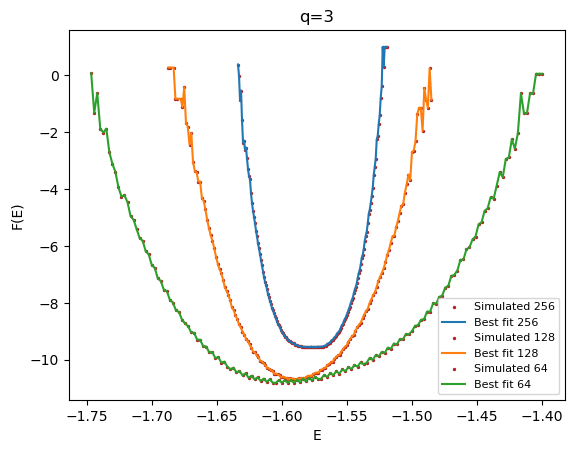

In [84]:
X=[E_256_3,E_128_3,E_64_3]
M=[256,128,64]
for i in range(len(X)):
    B_0=np.log(1+np.sqrt(3))
    B=B_0*0.99999
    E,F=E_hist(X[i],150,M[i],B,len(E_256_5)-10000)
    plt.scatter(E,F,s=2,c='firebrick',label='Simulated '+str(M[i]))
    x,y=E,F
    plt.xlabel('E')
    plt.ylabel('F(E)')
    plt.plot(x,y,ls='-',label='Best fit '+str(M[i]))
    plt.title('q=3')
    plt.legend(loc='lower right',fontsize=8)

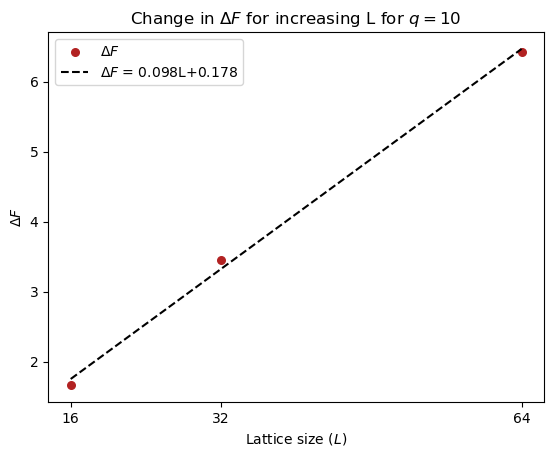

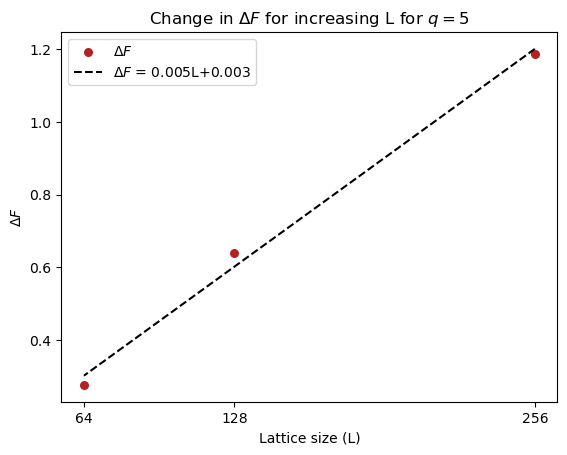

In [85]:
#q=10
L = np.array([16, 32, 64])
del_F = np.array([1.66597116, 3.45054134, 6.425703])
a,b = np.polyfit(L, del_F,1)

plt.scatter(L, del_F, c='firebrick', s=30, label=r'$\Delta F$')
plt.plot(L, a*L+b, c='k', ls='--', label=f'$\Delta F$ = {np.round(a,3)}L+{np.round(b,3)}')
plt.xticks(L)
plt.xlabel(r'Lattice size ($L$)', fontsize=10)
plt.ylabel(r'$\Delta F$', fontsize=10)
plt.legend()
plt.title(r'Change in $\Delta F$ for increasing L for $q=10$')
plt.show()

#q=5
L = np.array([256, 128, 64])
del_F = np.array([1.187803817, 0.639848861, 0.2768582109])
m,c = np.polyfit(L, del_F,1)

plt.scatter(L, del_F, c='firebrick', s=30, label=r'$\Delta F$')
plt.plot(L, m*L+c, c='k', ls='--', label=f'$\Delta F$ = {np.round(m,3)}L+{np.round(c,3)}')
plt.xticks(L)
plt.xlabel(r'Lattice size (L)', fontsize=10)
plt.ylabel(r'$\Delta F$', fontsize=10)
plt.legend()
plt.title(r'Change in $\Delta F$ for increasing L for $q=5$')
plt.show()